In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# EDA

In [135]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9473 entries, 0 to 9472
Data columns (total 3 columns):
fname                9473 non-null object
label                9473 non-null object
manually_verified    9473 non-null int64
dtypes: int64(1), object(2)
memory usage: 222.1+ KB


In [134]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 2 columns):
fname    9400 non-null object
label    9400 non-null object
dtypes: object(2)
memory usage: 147.0+ KB


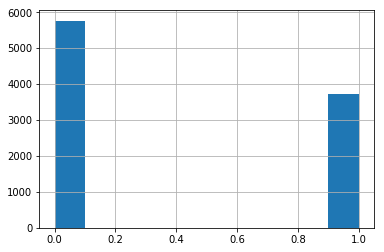

In [15]:
train['manually_verified'].hist()

## explore class distribution

In [18]:
train['label'].value_counts()

Squeak                   300
Cello                    300
Tearing                  300
Shatter                  300
Bass_drum                300
Clarinet                 300
Fireworks                300
Double_bass              300
Hi-hat                   300
Snare_drum               300
Acoustic_guitar          300
Saxophone                300
Applause                 300
Trumpet                  300
Laughter                 300
Violin_or_fiddle         300
Fart                     300
Flute                    300
Oboe                     299
Gong                     292
Knock                    279
Writing                  270
Cough                    243
Bark                     239
Tambourine               221
Burping_or_eructation    210
Cowbell                  191
Harmonica                165
Drawer_open_or_close     158
Meow                     155
Electric_piano           150
Gunshot_or_gunfire       147
Microwave_oven           146
Keys_jangling            139
Telephone     

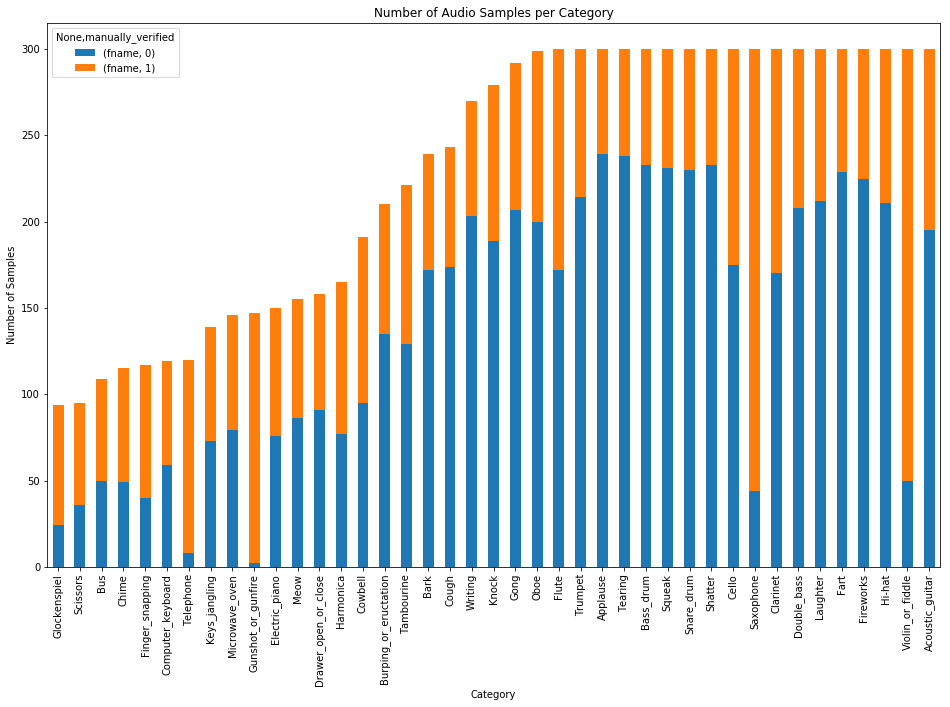

In [17]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [19]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


#### not the same number of audio samples for every class and some of the classes have been more manually verified than others

## exploring audio data

In [116]:
import IPython.display as ipd  # To play sound in the notebook
fname = 'data/audio_train/' + '0a0a8d4c.wav'   # clarinet
ipd.Audio(fname)

## interacting with the wave files

### using wave library

In [74]:
import wave

In [75]:
wav = wave.open(fname)

In [76]:
wav.getnframes()#gets number of frames in the wave file

176400

In [77]:
wav.getframerate()#gets the frame rate for the wave file

44100

### using scipy

In [78]:
from scipy.io import wavfile

In [79]:
rate,data = wavfile.read(fname)

In [80]:
rate #sampling rate

44100

In [81]:
data.shape#total number of samples

(176400,)

### visualize audio file

In [82]:
from scipy.signal import spectrogram

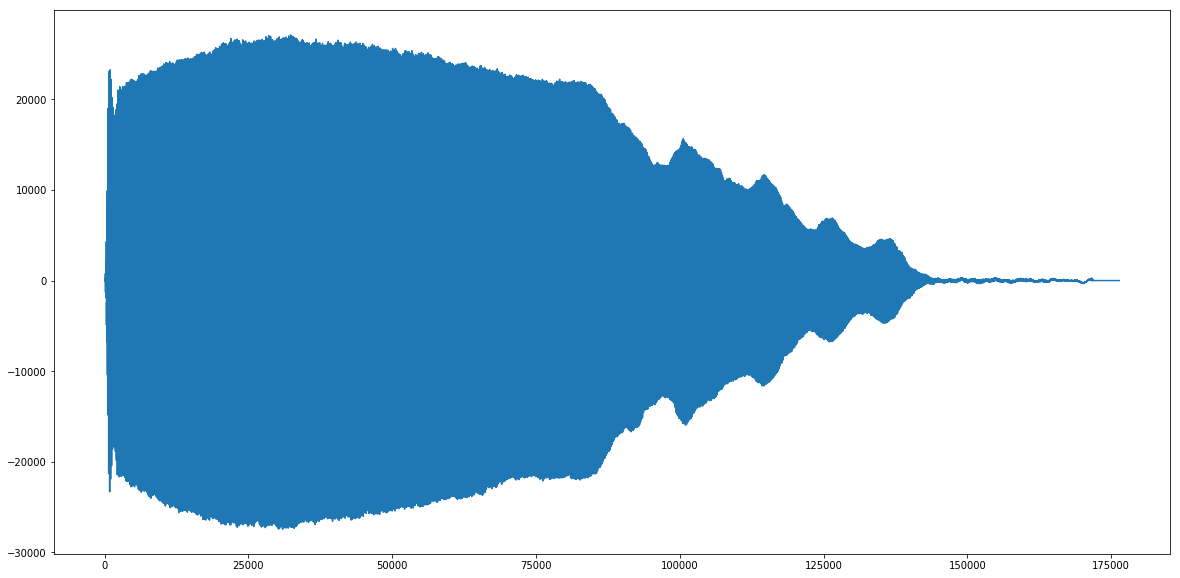

In [83]:
plt.figure(figsize=(20,10))
plt.plot(data)

In [112]:
f, t, Sxx = spectrogram(data,rate)

In [120]:
f

array([    0.      ,   172.265625,   344.53125 ,   516.796875,
         689.0625  ,   861.328125,  1033.59375 ,  1205.859375,
        1378.125   ,  1550.390625,  1722.65625 ,  1894.921875,
        2067.1875  ,  2239.453125,  2411.71875 ,  2583.984375,
        2756.25    ,  2928.515625,  3100.78125 ,  3273.046875,
        3445.3125  ,  3617.578125,  3789.84375 ,  3962.109375,
        4134.375   ,  4306.640625,  4478.90625 ,  4651.171875,
        4823.4375  ,  4995.703125,  5167.96875 ,  5340.234375,
        5512.5     ,  5684.765625,  5857.03125 ,  6029.296875,
        6201.5625  ,  6373.828125,  6546.09375 ,  6718.359375,
        6890.625   ,  7062.890625,  7235.15625 ,  7407.421875,
        7579.6875  ,  7751.953125,  7924.21875 ,  8096.484375,
        8268.75    ,  8441.015625,  8613.28125 ,  8785.546875,
        8957.8125  ,  9130.078125,  9302.34375 ,  9474.609375,
        9646.875   ,  9819.140625,  9991.40625 , 10163.671875,
       10335.9375  , 10508.203125, 10680.46875 , 10852.

In [126]:
Sxx

array([[8.24524918e+01, 5.56325684e+01, 1.29828223e+03, ...,
        3.23238055e-07, 2.97798465e-07, 4.10332717e-07],
       [7.71609802e+02, 8.28918438e+04, 2.96454344e+05, ...,
        8.51972072e-06, 5.62961359e-05, 1.41259778e-04],
       [1.51976465e+03, 3.92301953e+04, 2.61865531e+05, ...,
        6.31428848e-05, 6.16308898e-05, 6.94831033e-05],
       ...,
       [1.10233035e-04, 5.77661966e-04, 2.04461347e-02, ...,
        5.96397840e-05, 4.41399243e-05, 4.73556138e-05],
       [1.09940578e-04, 3.03188077e-04, 2.66259001e-03, ...,
        2.24881514e-05, 6.89274457e-05, 2.22779327e-05],
       [1.17655627e-05, 7.75866010e-06, 5.34358202e-03, ...,
        3.70533968e-08, 4.60091655e-07, 3.65421874e-05]], dtype=float32)

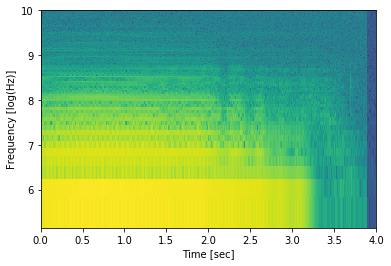

In [128]:
plt.pcolormesh(t, np.log(f[1:]), np.log(Sxx[1:]))
plt.ylabel('Frequency [log(Hz)]')
plt.xlabel('Time [sec]')
plt.show()

## exploring audio lengths

In [86]:
def get_nframes(fname):
    rate, data = wavfile.read(fname)
    return data.shape[0]

In [87]:
train['n_frames'] = train['fname'].apply(lambda fname: get_nframes(f'data/audio_train/{fname}'))

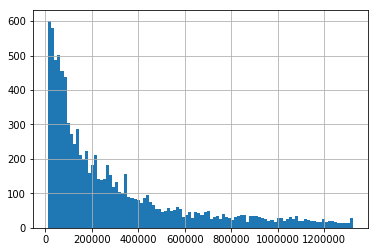

In [88]:
train['n_frames'].hist(bins=100)

#### need to be pad the shorter audio files to make them all the same length

### exploring audio amplitudes

In [59]:
def get_amplitude(fname):
    rate, data = wavfile.read(fname)
    return max(data)

In [61]:
train['amplitude'] = train['fname'].apply(lambda fname: get_amplitude(f'data/audio_train/{fname}'))

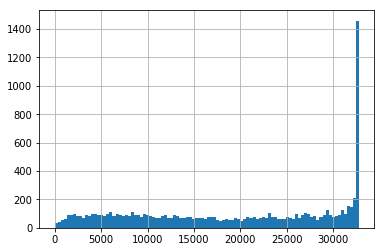

In [62]:
train['amplitude'].hist(bins=100)

#### definitely needs normalization.

# Modeling

### set this to true if you want to work with full data

In [132]:
full_data = False

In [136]:
if not full_data:
    train = train.sample(1000)
    test = test.sample(1000)

In [138]:
from keras.models import Sequential
from keras.layers.convolutional import Conv1D,MaxPooling1D,ZeroPadding1D


## baseline 1d CNN on raw waveforms

In [129]:
def Audio_Conv_1D():
    model = Sequential()
    model.add()

SyntaxError: unexpected EOF while parsing (<ipython-input-129-d4f07fc8c311>, line 1)